# Analyze historical data of five regions in AUS NEM
Methods in [1] are adopted, whose source code can be found in [2]. Besides, data in 'df_n','df_g' are also downloaded from [2].<br/>
This version was updated in Nov., 2021.

#### This code aims to ####
(1) Extract load data in the five trading region   in Australia National Electricity Market (AUS NEM) during 2015-2020 from  [3] ;<br />
(2) Examine $L^1$-, $L^2$- $L^\infty$- norms and absolute values of load vector and justify the proposed budgets.<br/>



##### NEM model #####
In total, the NEM  model consists of 203 generating units （conventional generators and renewable energy units), 912 nodes, and 1406 AC edges with line voltages in the range of 110 kV to 500 kV.

At the same time, there are ***5*** trading regions (NSW,QLD,SA,TAS,VIC) in daily operation [4], which are the focuses in this code.
    

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans

import scipy.io as sio
from pyomo.environ import *
import matplotlib.pyplot as plt


from random import random
from scipy.stats import multivariate_normal
from scipy.stats import matrix_normal

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

from matplotlib.path import Path
import matplotlib.patches as patches
import numpy.matlib
import matplotlib.transforms as transforms

##  Paths to directories

In [2]:
# Core data directory (common files)
data_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data'))

# MMSDM data directory
MMSDMdata_dir = os.path.join(data_dir,'AUS2011_2020')

# Network directory
network_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '1_network'))

# Generators directory
gens_dir = os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '2_generators'))

# Output directory
output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))
output_for_mat_dir=os.path.abspath(os.path.join(os.path.curdir, 'output_for_mat'))

# basic DataFrame for network (index=NODE_ID)
df_n = pd.read_csv(os.path.join(network_dir, 'output', 'network_nodes.csv'), index_col='NODE_ID', dtype={'NEAREST_NODE':np.int32})

# basic DataFrame for generator (index=DUID)
df_g = pd.read_csv(os.path.join(gens_dir, 'output', 'generators.csv'), dtype={'NODE': int}, index_col='DUID')

In [3]:
def Standardization(df_population):
    L=np.linalg.cholesky(df_population.cov().values)
    invL=np.linalg.inv(L)
    
    Zsample=np.dot(invL,(df_population-df_population.mean()).values.T)
    df_z=pd.DataFrame(Zsample).T

    return df_z

In [4]:
def TransformBack(df_z,df_population):
    L=np.linalg.cholesky(df_population.cov().values)
    n_samples=len(df_z)
    
    meann=np.array(df_population.mean())
    meann2=np.matlib.repmat(meann,n_samples,1)
    
    df_Pv=pd.DataFrame(meann2.T+np.dot(L,df_z.values.T))    
    return df_Pv.T


## Duration of the dataset

In [5]:
month_list=['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']
year_list=['2015','2016','2017','2018','2019','2020']
Missing_list=['20150601','20160101','20170701','20170801','20170901','20200601','20200701','20201201']

hiscom_year=['2015','2020']
hiscom_month=['0101','0501','0901','1101']

# Get load data
Load data in each NEM region are given at 30min intervals. Likewise, demand data are aggregated, with mean values over 60min intervals computed for each region. <br />

In [6]:
def get_zonal_load(df_TRADINGREGIONSUM_piv):
    def node_demand(row, df_regd):
        # row['NEM_REGION'] : define which trading region (the five) the node belongs to        
            return (row['PROP_REG_D']+ abs(0.5*np.random.normal()))* df_regd.loc[:, row['NEM_REGION']]
        
    df_nodal_d=df_n.apply(node_demand, args=(df_TRADINGREGIONSUM_piv,), axis=1).T            
    df_zonal_load=df_nodal_d.T.join(df_n[['NEM_ZONE']], how='left').groupby('NEM_ZONE').sum().T
    return df_zonal_load


## Read load data from the dataset

In [7]:
df_load_5Region=pd.DataFrame()

for year in year_list:
    for month in month_list:
        a=year+''+month
        if a in Missing_list:
            continue
        print(a)
        name_csv='PUBLIC_DVD_TRADINGREGIONSUM_201901010000.CSV'
        name_csv=name_csv.replace('0101',month)
        name_csv=name_csv.replace('2019',year)
        # Regional summary for each trading interval
        df_TRADINGREGIONSUM = pd.read_csv(os.path.join(MMSDMdata_dir, name_csv),
                                      skiprows=1, skipfooter=1, engine='python')
        # Convert settlement date to datetime
        df_TRADINGREGIONSUM['SETTLEMENTDATE'] = pd.to_datetime(df_TRADINGREGIONSUM['SETTLEMENTDATE'])
        # Pivot dataframe. Index is timestamp, columns are NEM region IDs, values are total demand
        df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM.pivot(index='SETTLEMENTDATE', columns='REGIONID', values='TOTALDEMAND')
        df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM_piv.groupby(pd.Grouper(freq='60Min', base=1, label='right')).mean()
        df_TRADINGREGIONSUM_piv = df_TRADINGREGIONSUM_piv.set_index(df_TRADINGREGIONSUM_piv.index - pd.Timedelta(minutes=1))

        df_load_5Region=df_load_5Region.append(df_TRADINGREGIONSUM_piv)
      

20150101
20150201
20150301
20150401
20150501
20150701
20150801
20150901
20151001
20151101
20151201
20160201
20160301
20160401
20160501
20160601
20160701
20160801
20160901
20161001
20161101
20161201
20170101
20170201
20170301
20170401
20170501
20170601
20171001
20171101
20171201
20180101
20180201
20180301
20180401
20180501
20180601
20180701
20180801
20180901
20181001
20181101
20181201
20190101
20190201
20190301
20190401
20190501
20190601
20190701
20190801
20190901
20191001
20191101
20191201
20200101
20200201
20200301
20200401
20200501
20200801
20200901
20201001
20201101


 Get standardized variable $\xi$

In [8]:
df_z_5Region=Standardization(df_load_5Region)


## Select "New castle" and "Queensland", and show the detailed data
### Plot $P_D^{NSW}$ and $P_D^{QLD}$

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(4500, 14500)

(3000, 12000)

Text(0.5, 0, 'Load in New South Wales (MW)')

Text(0, 0.5, 'Load in Queensland (MW)')

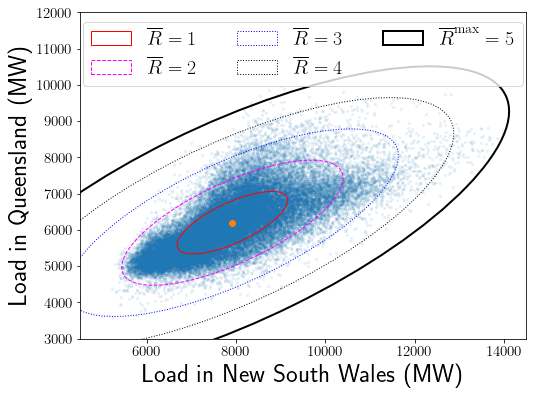

In [9]:
import matplotlib as mpl
rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)


x=df_load_5Region['NSW1']
y=df_load_5Region['QLD1']

cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

fig,ax=plt.subplots(figsize=(8, 6))
ax.scatter(x, y, alpha=0.1,linewidths=0.05,marker='.')

mean_x=np.mean(x)
mean_y=np.mean(y)
ax.scatter(mean_x, mean_y,linewidths=1)

#-------------Plot Confidence Ellipses-------
ell1 = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),facecolor='none',edgecolor='red',label='$\overline{R}=1$') 
ell2 = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*2*2, height=lambda_[1]*2*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),facecolor='none',edgecolor='fuchsia', linestyle='--',label='$\overline{R}=2$')
ell3 = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*3*2, height=lambda_[1]*3*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),facecolor='none',edgecolor='blue', linestyle=':',label='$\overline{R}=3$')
ell4 = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*4*2, height=lambda_[1]*4*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),facecolor='none',edgecolor='black', linestyle=':',label='$\overline{R}=4$')
ell5 = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*5*2, height=lambda_[1]*5*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),facecolor='none',edgecolor='black', linewidth=2 , linestyle='-',label='$\overline{R}^{\max}=5$')


c1=ax.add_patch(ell1)
c2=ax.add_patch(ell2)
c3=ax.add_patch(ell3)
c4=ax.add_patch(ell4)
c5=ax.add_patch(ell5)


font_legend = {'family' : 'Times New Roman','size': 20}
ax.legend(handles=[c1,c2,c3,c4,c5],frameon=True, prop=font_legend,ncol=3,loc='upper center')

plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
ax.set_xlim(4500, 14500)
ax.set_ylim(3000, 12000)

#plt.grid(linestyle=':',linewidth=0.5)

font3= {'family' : 'Times New Roman', 'size':25}
plt.xlabel('Load in New South Wales (MW)',font3)
plt.ylabel('Load in Queensland (MW)',font3)

plt.savefig(os.path.join(output_for_mat_dir,"NSW_QLD_Pv.png"),bbox_inches = 'tight')
plt.show()



### Plot $\xi^{NSW}$ and $\xi^{QLD}$

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-3.5, 6.5)

(-4.5, 8)

Text(0.5, 0, 'Standardized load in New South Wales (p.u.)')

Text(0, 0.5, 'Standardized load in Queensland (p.u.)')

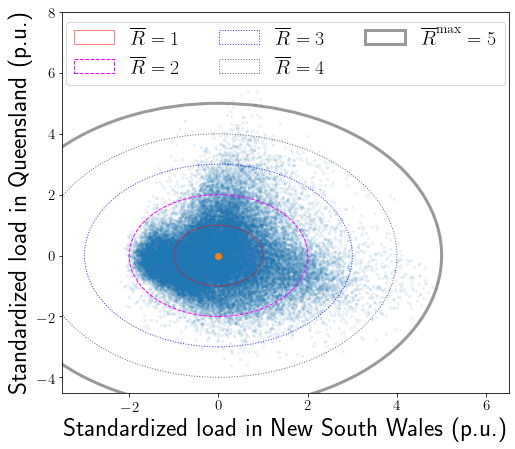

In [10]:
import matplotlib as mpl
rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)



fig,ax=plt.subplots(figsize=(8, 7))
ax.scatter(df_z_5Region[0], df_z_5Region[1], alpha=0.1,linewidths=0.05,marker='.')
ax.scatter(df_z_5Region[0].mean(), df_z_5Region[1].mean(),linewidths=1)

cir1 = Circle(xy = (0.0, 0.0), radius=1, alpha=0.5,facecolor='none',edgecolor='red',label='$\overline{R}=1$')
cir2 = Circle(xy = (0.0, 0.0), radius=2, alpha=1,facecolor='none',edgecolor='fuchsia', linestyle='--',label='$\overline{R}=2$')
cir3 = Circle(xy = (0.0, 0.0), radius=3, alpha=0.8,facecolor='none',edgecolor='blue', linestyle=':',label='$\overline{R}=3$')
cir4 = Circle(xy = (0.0, 0.0), radius=4, alpha=0.6,facecolor='none',edgecolor='black', linestyle=':',label='$\overline{R}=4$')
cir5 = Circle(xy = (0.0, 0.0), radius=5, alpha=0.4,facecolor='none',edgecolor='black', linewidth=3 , linestyle='-',label='$\overline{R}^{\max}=5$')

c1=ax.add_patch(cir1)
c2=ax.add_patch(cir2)
c3=ax.add_patch(cir3)
c4=ax.add_patch(cir4)
c5=ax.add_patch(cir5)




font_legend = {'family' : 'Times New Roman','size': 20}
ax.legend(handles=[c1,c2,c3,c4,c5],frameon=True, prop=font_legend,ncol=3,loc='upper center')

plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
ax.set_xlim(-3.5, 6.5)
ax.set_ylim(-4.5, 8)

#plt.grid(linestyle=':',linewidth=0.5)

font3= {'family' : 'Times New Roman', 'size':25}
plt.xlabel('Standardized load in New South Wales (p.u.)',font3)
plt.ylabel('Standardized load in Queensland (p.u.)',font3)

plt.savefig(os.path.join(output_for_mat_dir,"NSW_QLD_z.png"),bbox_inches = 'tight')
plt.show()


### Analyze $L^1$  norms at different $\overline{R}$

In [11]:
df_norm1_DiffR=pd.DataFrame(columns=['1','2','3','4','5','6','7','8'])

df_z_norm1=df_z_5Region.apply(lambda x: np.linalg.norm(x,ord=1),axis=1)
df_z_norm2=df_z_5Region.apply(lambda x: np.linalg.norm(x,ord=2),axis=1)


for i in range(1,9):
    mask=df_z_norm2<=i
    z_norm1_sub=df_z_norm1[mask]
    df_norm1_DiffR.loc['norm1',str(i)]=np.percentile(z_norm1_sub,95) 
    df_norm1_DiffR.loc['Pr',str(i)]=len(z_norm1_sub)/len(df_z_norm1)

In [12]:
  # L1 norm at different R's
    df_norm1_DiffR

,1,2,3,4,5,6,7,8
norm1,1.98637,3.78084,5.17723,6.11252,6.54892,6.81434,6.9563,6.99142
Pr,0.0520513,0.584336,0.881163,0.963089,0.984796,0.994584,0.998678,0.999872


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'MMD (i.e.,$\\overline{R}$) of the ellipsoid: $\\boldsymbol{\\xi}^{T}\\boldsymbol{\\xi} \\leq \\overline{R}^2$')

Text(0, 0.5, '$L^1$-norm (95\\% percentile)')

Text(0, 0.5, '$\\Pr\\{ L^2 $-norm $ \\leq \\overline{R}\\}$')

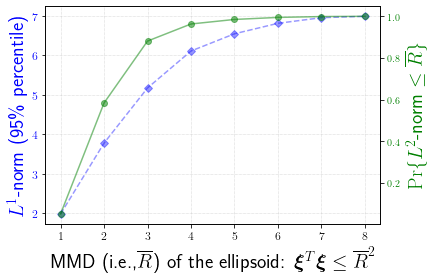

In [13]:
#plot the results
import matplotlib as mpl
rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)


font1= {'family' : 'Times New Roman', 'size':20}
fig1,ax1=plt.subplots()
x=np.arange(8)+1
y=np.array(df_norm1_DiffR.iloc[0])
line1=plt.plot(x,y,'bD--',alpha=0.4,label='$L^1$-norm (95\% percentile)')


plt.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.xlabel(r'MMD (i.e.,$\overline{R}$) of the ellipsoid: $\boldsymbol{\xi}^{T}\boldsymbol{\xi} \leq \overline{R}^2$',font1)
plt.ylabel('$L^1$-norm (95\% percentile)',font1,color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.grid(linestyle=':',linewidth=0.5,axis='both')

ax2 = ax1.twinx() 
y2=np.array(df_norm1_DiffR.iloc[1])
line2=ax2.plot (x,y2,'go-',alpha=0.5,label='$\Pr\{ L^2 $-norm $ \leq \overline{R} \}$')
ax2.set_ylabel('$\Pr\{ L^2 $-norm $ \leq \overline{R}\}$',font1,color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')
    
#lns = line1+line2
#labs = [l.get_label() for l in lns]
#ax2.legend(lns, labs, loc=4)


plt.savefig(os.path.join(output_for_mat_dir,"his_norm12.png"),bbox_inches = 'tight')

### Analyze absolute values at different $\overline{R}$

In [14]:
abs_z=df_z_5Region.apply(lambda x: abs(x),axis=1)

In [15]:
df_abs_DiffR=pd.DataFrame(columns=['1','2','3','4','5','6','7','8'])
for i in range(1,9):
    mask=df_z_norm2<=i
    z_abs_sub=abs_z[mask]
    
    for j in range(1,8):
        a=z_abs_sub<j
        num_lessThan=a.sum(axis=1)
    
        df_abs_DiffR.loc['num_absLessThan'+str(j),str(i)]=numpy.floor(num_lessThan.mean())

df_abs_DiffR

,1,2,3,4,5,6,7,8
num_absLessThan1,5,4,3,3,3,3,3,3
num_absLessThan2,5,5,4,4,4,4,4,4
num_absLessThan3,5,5,5,4,4,4,4,4
num_absLessThan4,5,5,5,5,4,4,4,4
num_absLessThan5,5,5,5,5,5,4,4,4
num_absLessThan6,5,5,5,5,5,5,4,4
num_absLessThan7,5,5,5,5,5,5,5,4


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'MMD (i.e.,$\\overline{R}$) of the ellipsoid: $\\boldsymbol{\\xi}^{T}\\boldsymbol{\\xi} \\leq \\overline{R}^2$')

Text(0, 0.5, 'Number of $\\xi_i$ in [-1,1]')

([<matplotlib.axis.YTick at 0x7fea7c5a1908>,
 <a list of 4 Text yticklabel objects>)

Text(0, 0.5, 'Number of $\\xi_i$ in [-2,2]')

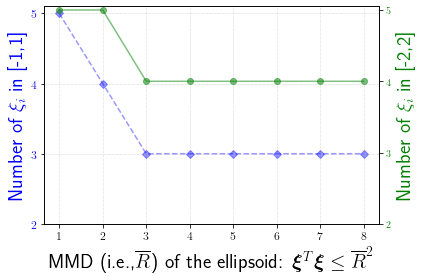

In [16]:
#plot the results
import matplotlib as mpl
rc_fonts = {
    "text.usetex": True,
    'text.latex.preview': True, # Gives correct legend alignment.
    'mathtext.default': 'regular',
    'text.latex.preamble': [r"""\usepackage{bm}"""],
}
mpl.rcParams.update(rc_fonts)


font1= {'family' : 'Times New Roman', 'size':20}
fig1,ax1=plt.subplots()
x=np.arange(8)+1
y=np.array(df_abs_DiffR.iloc[0])
line1=plt.plot(x,y,'bD--',alpha=0.4,label=r'Number of $\xi_i$ in [-1,1]')


plt.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.xlabel(r'MMD (i.e.,$\overline{R}$) of the ellipsoid: $\boldsymbol{\xi}^{T}\boldsymbol{\xi} \leq \overline{R}^2$',font1)
plt.ylabel(r'Number of $\xi_i$ in [-1,1]',font1,color='b')
plt.yticks(np.arange(2, 6, 1))
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.grid(linestyle=':',linewidth=0.5,axis='both')

ax2 = ax1.twinx() 
y2=np.array(df_abs_DiffR.iloc[1])

line2=ax2.plot (x,y2,'go-',alpha=0.5,label=r'Number of $\xi_i$ in [-2,2]')
ax2.set_yticks(np.arange(2, 6, 1))
ax2.set_ylabel(r'Number of $\xi_i$ in [-2,2]',font1,color='g')

for tl in ax2.get_yticklabels():
    tl.set_color('g')
    


plt.savefig(os.path.join(output_for_mat_dir,"his_abs.png"),bbox_inches = 'tight')

### Calculate the infinity norm

In [17]:
abs_z.max().max()

7.0562143011485885

# References
[1] -Xenophon, A., Hill, D. Open grid model of Australia’s National Electricity Market allowing backtesting against historic data. Sci Data 5, 180203 (2018). https://doi.org/10.1038/sdata.2018.203

[2] -Xenophon, A. K. Geospatial Modelling of Australia’s National Electricity Market. GitHub https://github.com/akxen/egrimod-nem (2018).

[3] -Australian Energy Markets Operator. Data Archive (2018). at http://www.nemweb.com.au/#mms-data-model 

[4] -Australian National Electricity Market https://www.aemc.gov.au/energy-system/electricity/electricity-system/NEM

#  Datasets List from MMSDM
A summary of the tables used from AEMO's MMSDM database [3] is given below:

| Table | Description |
| :----- | :----- |
|DISPATCH_UNIT_SCADA | MW dispatch at 5 minute (dispatch) intervals for DUIDs within the NEM.|
|TRADINGREGIONSUM | Contains load in each NEM region at 30 minute (trading) intervals.|